

# Uploading and processing data



In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


Extract data


In [ ]:
#execute once
import zipfile

zip_path = '/content/gdrive/My Drive/TM_PROJECT/blogs.zip'

extract_path = '/content/gdrive/My Drive/TM_PROJECT'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
from bs4 import BeautifulSoup
import os
import pickle

def process_xml_file(file_path):

    with open(file_path, 'r', encoding='latin-1') as file:
        content = file.read()

    soup = BeautifulSoup(content, 'xml')
    posts = []

    for post in soup.find_all('post'):
        posts.append(post.get_text(strip=True))

    return posts

def extract_age_from_filename(filename, parts):
    parts = filename.split('.')
    age = parts[2]  #the age is at the third position in the filename structure
    return age



directory = '/content/gdrive/My Drive/TM_PROJECT/blogs'

text_data = []
age_labels = []


#go through all files in directory
for filename in os.listdir(directory):
    if filename.endswith('.xml'):
        parts = filename.split('.')
        file_path = os.path.join(directory, filename)
        posts = process_xml_file(file_path)
        age = extract_age_from_filename(filename, parts)

        if posts:
            combined_posts = ' '.join(posts)
            text_data.append(combined_posts)
            age_labels.append(age)


#serialization
pickle_file_path = '/content/gdrive/My Drive/TM_PROJECT/data.pkl'

if not os.path.exists(pickle_file_path): #if file is not existing
    with open(pickle_file_path, 'wb') as file: #write binary
        pickle.dump((text_data, age_labels), file)

In [ ]:
#load data back using pickle
import pickle
pickle_file_path = '/content/gdrive/My Drive/TM_PROJECT/data.pkl'
with open(pickle_file_path, 'rb') as file: #read binary
    text_data, age_labels, gender_labels = pickle.load(file)

**Changing age for age_range**

In [ ]:
def convert_to_age_range(age):
  if 13 <= int(age) <= 17:
    return '13-17'
  elif 23 <= int(age) <= 27:
    return '23-27'
  elif 33 <= int(age) <= 47:
    return '33-47'
  else:
    return 'Other'

age_labels = [convert_to_age_range(age) for age in age_labels]

# PREPROCESSING

In [ ]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    text = text.lower()
    return text


def preprocess_text(text):
    text = clean_text(text)
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return ' '.join(tokens)

#applying preprocessing to each blog post
preprocessed_text_data = [preprocess_text(post) for post in text_data]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


#Embeeding and classification

In [ ]:
pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 925.4 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.11.1-py3-none-any.whl (227 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4199774 sha256=8d33880a9ae1189e26789f29289a2973b6b8fc129e866d94ed8271ceb7cee4f3
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import fasttext.util

#loading FastText model
fasttext.util.download_model('en', if_exists='ignore')
ft_model = fasttext.load_model('cc.en.300.bin')

#vectorize text with FastText
def vectorize_text(text):
    words = text.split()
    word_vectors = [ft_model.get_word_vector(word) for word in words]
    return sum(word_vectors) / len(word_vectors)

In [ ]:
#vectorizing each blog post
vectorized_data = [vectorize_text(post) for post in preprocessed_text_data]

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

X_train, X_test, y_train, y_test = train_test_split(vectorized_data, age_labels, test_size=0.2, random_state=42)

#classifiers
svc = SVC()
random_forest = RandomForestClassifier()
neural_network = MLPClassifier()
clf = DecisionTreeClassifier()

for classifier in [svc, random_forest, neural_network, clf]:
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"Metrics for {classifier.__class__.__name__}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}\n")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics for SVC:
Accuracy: 0.7054865424430642
Precision: 0.622960111484981
Recall: 0.7054865424430642
F1 Score: 0.6522651349941868



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics for RandomForestClassifier:
Accuracy: 0.6790890269151139
Precision: 0.6710008384271616
Recall: 0.6790890269151139
F1 Score: 0.6519414550262085



/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics for MLPClassifier:
Accuracy: 0.7575051759834368
Precision: 0.751080253375395
Recall: 0.7575051759834368
F1 Score: 0.745981619866796

Metrics for DecisionTreeClassifier:
Accuracy: 0.5778985507246377
Precision: 0.5817979417546536
Recall: 0.5778985507246377
F1 Score: 0.5797931984715349



**CHECKING THE DISTRIBIUTION**

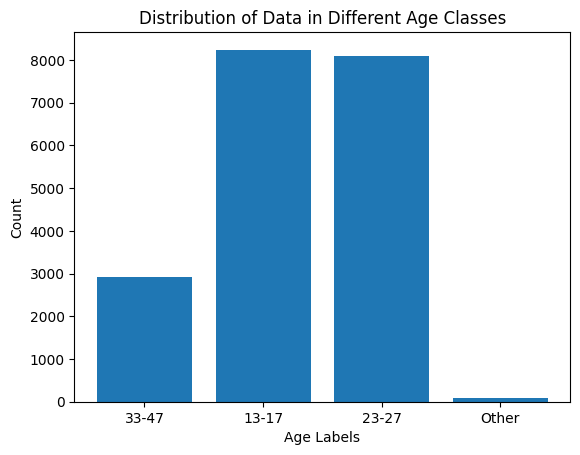

Label: 33-47, Count: 2917
Label: 13-17, Count: 8240
Label: 23-27, Count: 8086
Label: Other, Count: 77


In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

#create a Counter to count occurrences of each label
label_counts = Counter(age_labels)

#plotting the distribution
labels, counts = zip(*label_counts.items())

plt.bar(labels, counts)
plt.xlabel('Age Labels')
plt.ylabel('Count')
plt.title('Distribution of Data in Different Age Classes')
plt.show()

#printing counts for each label
for label, count in label_counts.items():
    print(f"Label: {label}, Count: {count}")